Get PV correlation means and stds for a power calculation.

In [2]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    # sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sd_paper/analysis_and_figure_code/DataPaths'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
    group_data_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/Clustering/grpdata")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        plot_dir = Path('/data/Clustering/plots')
        group_data_dir = Path('/data/Clustering/grpdata')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])


    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy
from tqdm import tqdm

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO

import subjects
from plotters import Plotter, get_nsd_vs_sd_df, add_parametric_extras, stats_to_df, filter_stats_df
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Set parameters for place fields

In [3]:
frate_thresh = 3  # must have at least one bin above this value to be considered a place field

## Load in previously calculated place field tuning curves

In [4]:
tc_all = pd.read_csv(group_data_dir / "tc_all.csv", index_col=0)
tc_all

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,session,grp
0,0.000000,0.000000,0.664043,0.298140,1.202241,0.639808,0.120662,0.020136,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0,NSD
1,0.207612,0.012711,0.027668,0.204733,0.090885,0.034121,0.130268,0.080546,0.000000,0.000000,...,0.000000,0.000000,0.235479,0.388540,0.000000,0.000000,0.000000,0.000000e+00,0,NSD
2,1.038062,1.272878,1.153802,1.481709,1.286844,0.946563,0.633890,0.419685,0.720616,0.879570,...,0.580255,0.268528,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0,NSD
3,2.906574,2.131475,1.057192,0.486249,0.376315,0.178261,0.123277,0.225562,0.141560,0.000000,...,0.300752,0.565374,1.065125,1.165620,0.000000,0.000000,0.000000,0.000000e+00,0,NSD
4,13.702422,7.676248,5.706135,4.906915,5.382127,8.943502,12.748299,16.544660,17.539733,14.345243,...,0.559006,0.296846,0.358689,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0,NSD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,0.000000,0.202666,0.264557,0.146939,0.000000,0.000000,0.147529,0.088235,0.024507,0.000000,...,7.706031,15.771429,4.860202,0.057286,0.000000,0.000000,0.000000,0.000000e+00,7,SD
918,2.101167,0.153854,0.195986,0.319734,0.778995,0.995184,1.200739,1.676471,1.105364,2.749186,...,1.294102,9.959184,6.867298,3.100058,6.270836,4.988732,1.415816,0.000000e+00,7,SD
919,0.000000,0.146437,0.000000,0.000000,0.107591,0.092978,0.000000,0.000000,0.185730,0.109684,...,0.000000,0.000000,0.000000,1.004710,0.250683,0.000000,0.000000,0.000000e+00,7,SD
920,1.400778,3.562097,4.106440,3.507618,3.904169,5.688379,2.861642,2.470588,1.897298,0.966948,...,0.000000,0.000000,0.000000,0.000000,0.716775,5.439288,0.918367,-4.440892e-16,7,SD


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid v

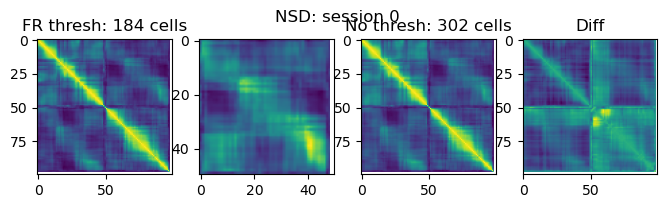

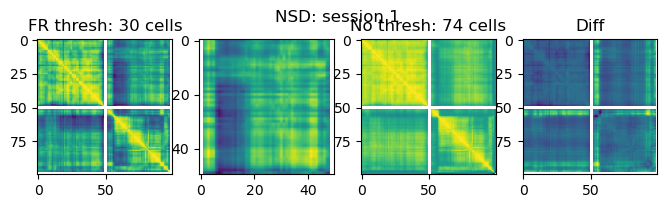

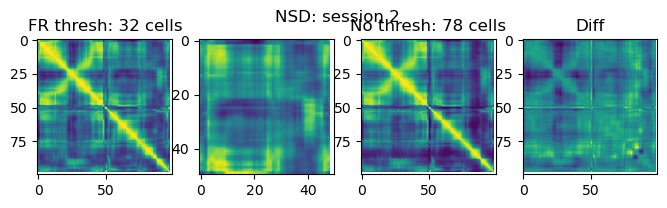

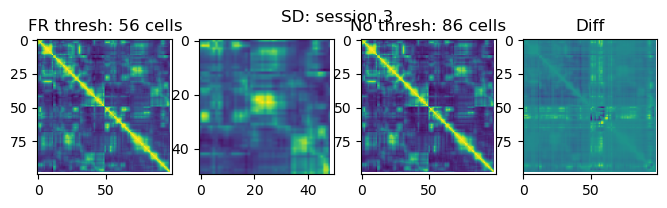

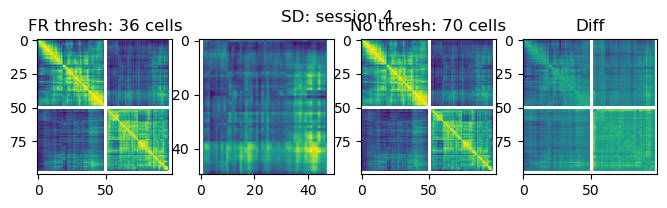

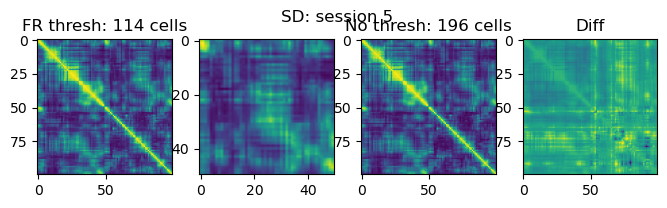

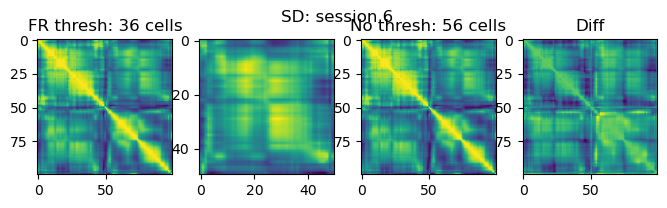

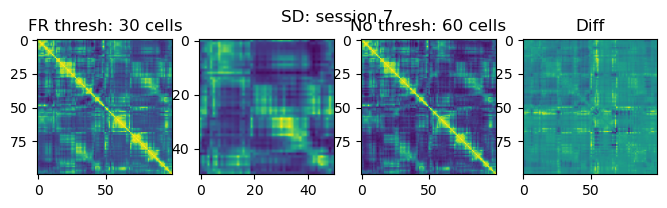

In [5]:
nbins_per_sesh = 50

corrs_diag_df = []
for grp in ["NSD", "SD"]:
    tc_grp = tc_all[tc_all.grp == grp]
    
    for sid in tc_grp.session.unique():
        fig, ax = plt.subplots(1, 4, figsize=(8, 2))

        # Load in tuning curves all with the same # bins (and therefore different sizes..., approximate)
        # bins 0:nbins_per_sesh = MAZE, nbins_per_sesh: = reMAZE
        tc_sesh = tc_grp[tc_grp.session == sid]

        # FR threshold - only include cells with FR above thresh in MAZE
        frate_bool = tc_sesh.iloc[:, :nbins_per_sesh].max(axis=1) > frate_thresh
        tc_sesh_thresh = tc_sesh[frate_bool]

        # Get PV correlation matrix
        corr_array = np.corrcoef(tc_sesh_thresh.drop(columns=["session", "grp"]).to_numpy().T)
        corr_array_no_thresh = np.corrcoef(tc_sesh.drop(columns=["session", "grp"]).to_numpy().T)

        # Plot it for a sanity check
        ax[0].imshow(corr_array)
        corr_maze_rmaze = corr_array[0:nbins_per_sesh, nbins_per_sesh:]
        ax[0].set_title(f"FR thresh: {frate_bool.sum()} cells")
        
        ax[1].imshow(corr_maze_rmaze)
        fig.suptitle(f"{grp}: session {sid}")

        ax[2].imshow(corr_array_no_thresh)
        ax[2].set_title(f"No thresh: {frate_bool.shape[0]} cells")

        ax[3].imshow(corr_array - corr_array_no_thresh)
        ax[3].set_title("Diff")

        # save correlations along diagonal (same bin from MAZE to reMAZE) 
        diag_corrs = pd.DataFrame(corr_maze_rmaze[np.eye(50, dtype=bool)][None, :], index=[sid])
        diag_corrs["session"] = sid
        diag_corrs["grp"] = grp
        
        corrs_diag_df.append(diag_corrs)

corrs_diag_df = pd.concat(corrs_diag_df, axis=0)

In [6]:
corrs_diag_df

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,session,grp
0,0.081268,0.294919,0.246253,0.246150,0.191208,0.164654,0.120352,0.112337,0.156578,0.219058,...,0.411848,0.389735,0.418294,0.366140,0.327029,0.049176,-0.013047,NaN,0,NSD
1,NaN,0.468271,0.563058,0.760690,0.503543,0.468983,0.173611,0.301395,0.333705,0.318962,...,0.809022,0.812482,0.638845,0.565172,0.511426,0.348890,0.220360,NaN,1,NSD
2,0.412295,0.195081,0.378981,0.590836,0.590389,0.602377,0.634672,0.652582,0.586659,0.528109,...,0.014544,0.127752,0.336253,0.367770,0.585009,0.526484,0.371905,NaN,2,NSD
3,0.198442,0.481060,0.729800,0.398021,0.288125,0.345102,0.033713,0.143327,-0.015383,-0.005027,...,0.386282,0.133076,0.272335,0.399739,0.623686,0.656721,0.445287,NaN,3,SD
4,NaN,0.082215,-0.006131,-0.128823,0.022302,0.113814,0.123021,-0.019279,0.133618,0.056086,...,0.580012,0.568575,0.367525,0.251592,0.166130,0.366302,NaN,NaN,4,SD
5,0.776585,0.892453,0.795748,0.582324,0.372126,0.314647,0.150201,-0.002355,0.062521,0.093921,...,0.460889,0.366690,0.326689,0.432170,0.619344,0.533516,0.621507,0.445512,5,SD
6,0.481589,0.543587,0.645612,0.323791,0.399994,0.348483,0.581347,0.585692,0.670229,0.684563,...,0.585868,0.590747,0.583094,0.605872,0.217167,0.208918,0.101646,-0.025227,6,SD
7,0.230870,-0.046686,0.233478,0.316386,0.502277,0.230707,0.316249,0.492819,0.364017,0.347651,...,0.313272,0.417176,0.659701,0.610548,0.532045,0.154930,0.350021,-0.113965,7,SD


## Now do power calculation

### First calculate PV mean and std

In [7]:
PV_mean = corrs_diag_df.groupby(["grp", "session"]).apply(lambda x: np.nanmean(x, axis=1)[0]).reset_index().rename(columns={0: "PVmean"})
PV_mean

,grp,session,PVmean
0,NSD,0,0.265087
1,NSD,1,0.491471
2,NSD,2,0.236726
3,SD,3,0.332801
4,SD,4,0.116238
5,SD,5,0.367790
6,SD,6,0.550084
7,SD,7,0.360835


In [8]:
sesh_mean = PV_mean.drop(columns="session").mean(numeric_only=True).values[0]
sesh_std = PV_mean.drop(columns="session").std(numeric_only=True).values[0]

### Second plot session means
Looks like there is no difference in "drift" between NSD and SD.  

That's ok, use the overall group mean and variance to perform power calculation

<Axes: xlabel='grp', ylabel='PVmean'>

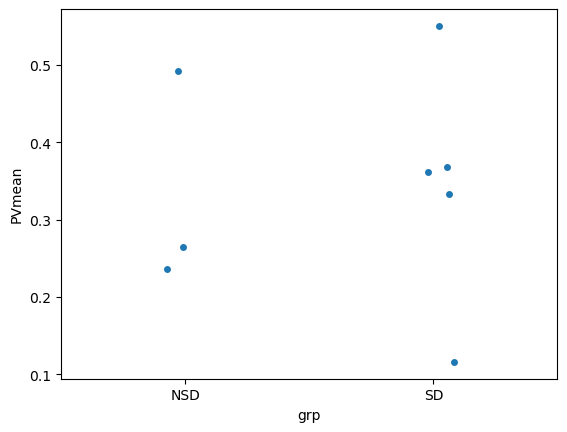

In [9]:
_, ax = plt.subplots()
sns.stripplot(data=PV_mean, x="grp", y="PVmean", dodge=True, ax=ax)

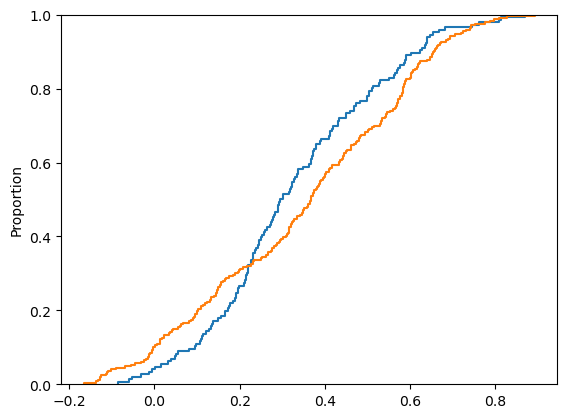

In [10]:
_, ax = plt.subplots()
for grp in ["NSD", "SD"]:
    sns.ecdfplot(data=corrs_diag_df[corrs_diag_df.grp == grp].drop(columns=["grp", "session"]).to_numpy().reshape(1, -1).squeeze(), ax=ax)

### Power calculation!
Assume the mean and standard deviation for PV correlations from above. This is much smaller than observed by Mankin et al. (2012) which is probably due to differences in methodology.

She finds PV (10 min gap) =  0.85, and PV (6 hr gap) =  0.7, so a 0.15 change from AM to PM (6 hour diff) in CA1. Assume we want to detect between group differences of around that magnitude, so use variance from above to do power calculation.

In [25]:
stats.ttest_ind_from_stats(0, sesh_std, 8, 0.15, sesh_std, 8)

Ttest_indResult(statistic=-2.162777671989081, pvalue=0.04835149198735069)

So, we get a p-value of 0.048 using a group size of 8, assuming the variance above. This would allow us to detect changes on the order of what we would expect from Mankin et al. (2012) under normal sleep conditions.

In [97]:
stats.ttest_ind(PV_mean[PV_mean.grp == "NSD"].PVmean.values - , PV_mean[PV_mean.grp == "SD"].PVmean.values)

TtestResult(statistic=-1.3221594541371509, pvalue=0.23428137191387577, df=6.0)

## Place field stability power analysis next
Logic: Get mean PF corr from MAZE-reMAZE across all sessions, estimate mean and std (s.e.m.?), compare to chance (calculated from shuffles).

Could also only permute some cells (say 50%) to see the n required to detect instability in that # of cells.

### First estimate chance-level correlations to get a baseline for instability

In [86]:
shuf_corrs_df, corrs_df = [], []
for sid in tc_all.session.unique():
    tc_sesh = tc_all[tc_all.session == sid]
    grp = tc_sesh.grp.values[0]    
    tc_sesh = tc_sesh.drop(columns=["grp", "session"]).to_numpy()
    nshuf = 100
    shuf_corrs = []
    tc1 = tc_sesh[:, 0:nbins_per_sesh]
    tc2 = tc_sesh[:, nbins_per_sesh:]
    ncells = tc_sesh.shape[0]
    corrs_actual, shuf_corrs = [], []

    for tcm, tcrm in zip(tc1, tc2):
        corrs_actual.append(np.corrcoef(tcm, tcrm)[0][1])
        
    for n in range(nshuf):
        tc2shuf = tc2[np.random.permutation(ncells)]
        shuf_corrs_sesh = []
        for tc, tcshuf in zip(tc1, tc2shuf):
            shuf_corrs_sesh.append(np.corrcoef(tc, tcshuf)[0][1])
        shuf_corrs.append(np.nanmean(shuf_corrs_sesh))
    df_shuf_temp = pd.DataFrame(np.array(shuf_corrs)[None,:])
    df_shuf_temp["grp"] = grp
    df_shuf_temp["session"] = sid
    shuf_corrs_df.append(df_shuf_temp)

    df_temp = pd.DataFrame(corrs_actual)
    df_temp["grp"] = grp
    df_temp["session"] = sid
    corrs_df.append(df_temp)

shuf_corrs_df = pd.concat(shuf_corrs_df, axis=0, ignore_index=True)
corrs_df = pd.concat(corrs_df, axis=0, ignore_index=True)

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid v

Mean and std of shuffle is basically zero, so compare place field means to 0 for power calculation.

In [83]:
shuf_corrs_df.groupby(["grp", "session"]).apply(lambda x: np.nanmean(x, axis=1)[0])

grp  session
NSD  0          0.009100
     1         -0.003590
     2          0.017939
SD   3          0.032629
     4          0.008350
     5         -0.002269
     6          0.038399
     7          0.006739
dtype: float64

In [82]:
shuf_corrs_df.groupby(["grp", "session"]).apply(lambda x: np.nanstd(x, axis=1)[0])

grp  session
NSD  0          0.014207
     1          0.024999
     2          0.025911
SD   3          0.023195
     4          0.021988
     5          0.013531
     6          0.036166
     7          0.022950
dtype: float64

### Do power calculation: check for sample size needed to get statistically different value from chance level.

Note that these are slightly lower than shown for manuscript due to differences in binning and smoothing. Use anyway because they are lower and therefore more conservative.

In [91]:
corrs_mean = corrs_df.groupby(["grp", "session"]).mean()
corrs_mean

0
grp session          
NSD 0        0.174631
    1        0.133646
    2        0.129458
SD  3        0.273854
    4        0.045033
    5        0.168793
    6        0.263107
    7        0.229157

In [101]:
mean_use = corrs_mean.mean()[0]
std_use = corrs_mean.std()[0]

Required n value is 3, which is very low. At n = 8 we get a p-value of 0.00039!!!

In [107]:
stats.ttest_ind_from_stats(0, std_use, 3, mean_use, std_use, 3)

Ttest_indResult(statistic=-2.830959369410909, pvalue=0.04729900449868008)

In [108]:
stats.ttest_ind_from_stats(0, std_use, 8, mean_use, std_use, 8)

Ttest_indResult(statistic=-4.622937291738636, pvalue=0.0003948605363596361)

## Now for splitters

Rationale: reducing inhibition will increase peak FRs to erase differences in L v R rates for splitters and widen fields to reduce differences between tuning curves for shifters.

Approach: Estimate change in FR (from my own data? only 3 pyr cells which is a bit rough) at peak and width increase from Grienberger et al. (2016).